# Separating LSB Galaxies from LSB artefacts using Deep Learning

In [1]:
#Import stuff
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'


# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

## Part I: Import the data and show examples

In [2]:
LSBG_data = np.float64(np.load("LSBG_sample.npy"))/255.
Neg_1_data = np.float64(np.load("Negative_sample_1.npy"))/255.
Neg_2_data = np.float64(np.load("Negative_sample_2.npy"))/255.

Let's display some examples...

- First of LSBGs:

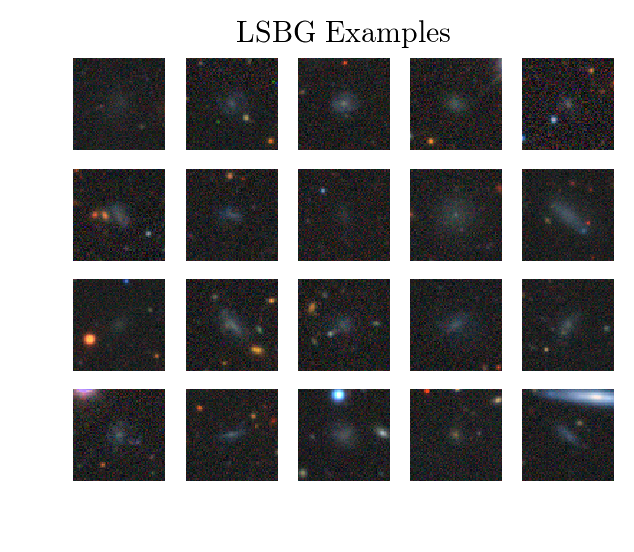

In [3]:
subset_LSBG = LSBG_data[0:20,:]subset_LSBG = LSBG_data[0:20,:]

nrows = 4
ncols = 5

plt.figure(figsize=(ncols*0.7, nrows*0.7))

for i in range(nrows*ncols):
    if (i==3):
        plt.title("LSBG Examples")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(subset_LSBG[i])
    plt.axis('off')
    
plt.axis('off')
plt.show()

- Now let's show some examples of LSB artefacts

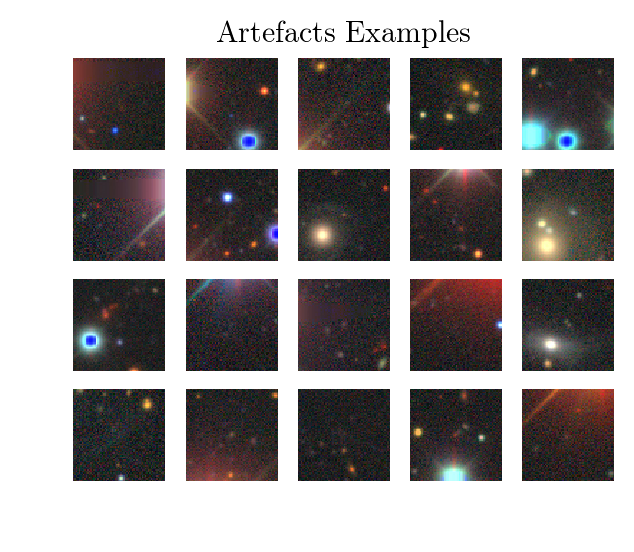

In [4]:
subset_Neg1 = Neg_1_data[0:20,:]

nrows = 4
ncols = 5

plt.figure(figsize=(ncols*0.7, nrows*0.7))

for i in range(nrows*ncols):
    if (i==3):
        plt.title("Artefacts Examples")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(subset_Neg1[i])
    plt.axis('off')
    
plt.axis('off')
plt.show()

- And some examples of those objects that passed the ML classification but I visually rejected.

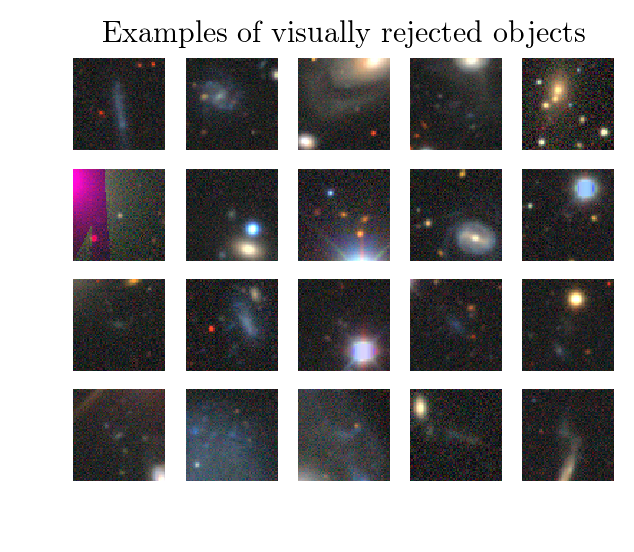

In [5]:
subset_Neg2 = Neg_2_data[40:60,:]

nrows = 4
ncols = 5

plt.figure(figsize=(ncols*0.7, nrows*0.7))

for i in range(nrows*ncols):
    if (i==3):
        plt.title("Examples of visually rejected objects")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(subset_Neg2[i])
    plt.axis('off')
    
plt.axis('off')
plt.show()

## Part II: Deep Learning Classification

In this part I will train a Convolutional Neural Network (CNN) to distinguish between LSBGs and spurious LSB detections.

As we saw above, we have three samples: 

- A sample of Low Surface Brightness Galaxies (LSBGs) - 1000 instances. 

- A sample of LSB artefacts that were eliminated in the ML classfication part, as described in (Tanoglidis, Drlica-Wagner et. al., 2020). Let's call this `Negative sample 1`. - 1000 instances.

- A sample of LSB objects/artefacts that passed the ML classification part (were classified as positives) but were rejected upon visual inspection. Let's call this `Negative sample 2` - 1000 instances. L

Now this third sample is quite tricky. It does not include only photographic artefacts (that constitute the vast majority of cases of the `Negative sample 1`), but also LSB objects as spires and tails of galaxies, examples of galactic cirrus, LSB objects that - after visual inspection - looked too compact to be included in the catalog, and even cases of duplicates. So, generally these objects are much more challenging to classify.

So, in the following, I will consider the following cases:

- A **binary** classification problem, with positive class the LSBGs and negative class the `Negative sample 1`. This should achieve a high accuracy, since these two classes correspond to those produced by the simple, "conventional" SVM machine learning model.

- A **binary** classification problem, with positive class the LSBGs and negative class the `Negative sample 2`. This is the challenging part, and the one that will show if our method is meaningful, since this is the sample that was missclassified by the SVM classifier and I had to visually reject it.

- A **three-label** classification problem, with the following classes:  
     - LSBGs
     - `Negative sample 1`
     - `Negative sample 2`

In all cases I will use the following simple CNN architecture:

![alt text](LSBG_gals.jpg "Title")



### Case I: Binary classification, LSBGs vs `Negative_sample_1` (Artefacts)

In [6]:
import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import train_test_split

In [7]:
X_mat_ft1 = np.concatenate((LSBG_data,Neg_1_data)) # Features matrix
y_labels_ft1 = np.concatenate((np.ones(1000),np.zeros(1000))) # Labels 

# =====================================================================
# =====================================================================
# Now split in training, validation and test sets

# First in training and a set for validation and test - training set has 1500 instances 
X_tr1, X_valt1, y_tr1, y_valt1 = train_test_split(X_mat_ft1, y_labels_ft1, test_size=0.25, random_state=42)

# Now split in validation and test sets - 250 instances each
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_valt1, y_valt1, test_size=0.50, random_state=42)

In [8]:
# build the  original model
model = keras.models.Sequential()
model.add(keras.layers.InputLayer((64,64,3)))
model.add(keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=1024, activation='relu'))
model.add(keras.layers.Dense(units=1, activation='sigmoid'))
model.compile(optimizer=tf.train.AdadeltaOptimizer(0.1),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
model.fit(x=X_tr1, y=y_tr1,
          epochs=20, batch_size=16,
          shuffle=True,
          validation_data=(X_val1,y_val1))

Train on 1500 samples, validate on 250 samples
Epoch 1/20
1500/1500 [==============================] - 21s 14ms/step - loss: 0.6344 - acc: 0.6453 - val_loss: 0.5903 - val_acc: 0.8920
Epoch 2/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.4497 - acc: 0.8540 - val_loss: 0.3825 - val_acc: 0.9480
Epoch 3/20
1500/1500 [==============================] - 15s 10ms/step - loss: 0.2806 - acc: 0.9147 - val_loss: 0.2474 - val_acc: 0.9680
Epoch 4/20
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2347 - acc: 0.9133 - val_loss: 0.1997 - val_acc: 0.9600
Epoch 5/20
1500/1500 [==============================] - 17s 11ms/step - loss: 0.2143 - acc: 0.9207 - val_loss: 0.1973 - val_acc: 0.9440
Epoch 6/20
1500/1500 [==============================] - 18s 12ms/step - loss: 0.1876 - acc: 0.9380 - val_loss: 0.1609 - val_acc: 0.9680
Epoch 7/20
1500/1500 [==============================] - 16s 10ms/step - loss: 0.1745 - acc: 0.9353 - val_loss: 0.1640 - val_acc: 0.9600
E

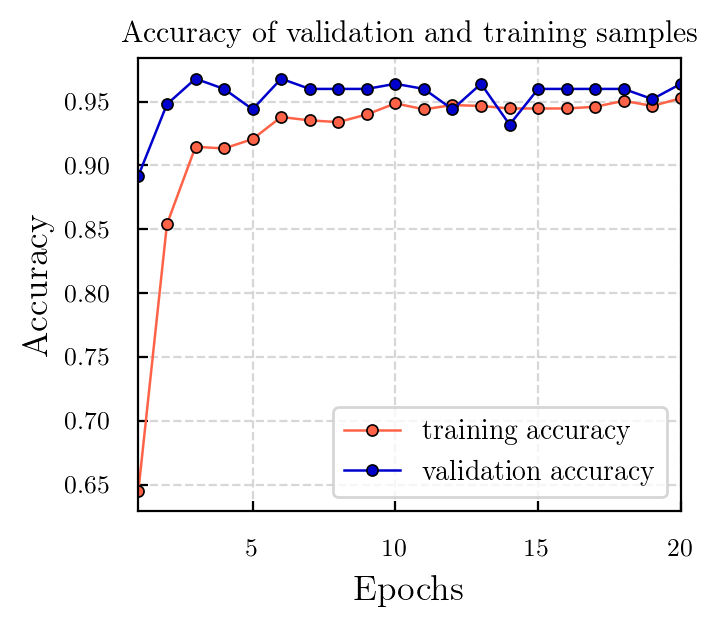

In [10]:
Epochs = np.arange(1,21,1)
history_dict = model.history.history

train_acc = history_dict['acc']
val_acc = history_dict['val_acc']
train_err = 1.0 - np.asarray(train_acc)
val_err = 1.0 - np.asarray(val_acc)

plt.figure(figsize=(3.5, 3.0))

plt.plot(Epochs, train_acc, c = 'tomato', marker='o',
         markersize=4,linewidth=0.9,markeredgecolor='k',
         markeredgewidth=0.6,label='training accuracy')
plt.plot(Epochs, val_acc , c = 'mediumblue', marker='o',
         markersize=4,linewidth=0.9,markeredgecolor='k',
         markeredgewidth=0.6,label='validation accuracy')

plt.grid(ls='--',alpha=0.5)
plt.xlabel('Epochs', fontsize=13);plt.ylabel('Accuracy',fontsize=13)
plt.title('Accuracy of validation and training samples')
plt.xlim(1,20)

plt.legend(frameon=True, loc='lower right', fontsize=10)
plt.show()

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [13]:
# Now predict on the test set
y_pred_1 = model.predict_classes(X_test1)
# Calculate the accuracy score of the model
acc_model1 = accuracy_score(y_test1, y_pred_1)
print(acc_model1)

0.924


We have an accuracy 92.4 $\%$ on the test set.

Let's plot the confusion matrix to see better what is going on.

In [14]:
con_mat = confusion_matrix(y_test1, y_pred_1).T
con_mat = con_mat.astype(float)
class_names = ['LSBGs', 'Artefacts']

norm_1 = np.sum(con_mat[0,:])
norm_2 = np.sum(con_mat[1,:])

con_mat[0,:] = con_mat[0,:]/np.float(norm_1)
con_mat[1,:] = con_mat[1,:]/np.float(norm_2)

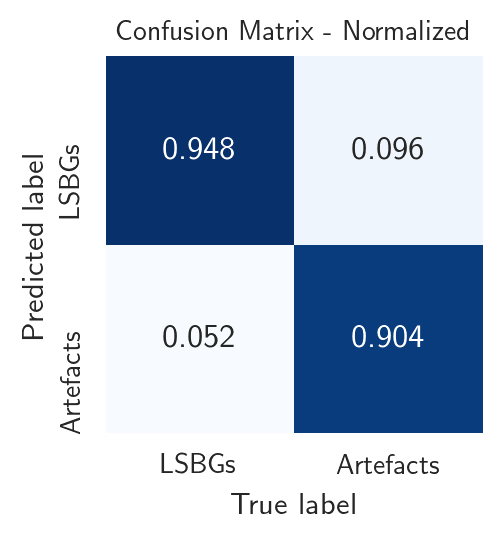

In [18]:
plt.figure(figsize = (2.5,2.5))
plt.title('Confusion Matrix - Normalized',fontsize=10)
sns.heatmap(con_mat.T, square = True, annot=True, fmt='.3f', cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)

plt.xlabel('True label')
plt.ylabel('Predicted label')

plt.show()

Let's plot the unnormalized matrix as well

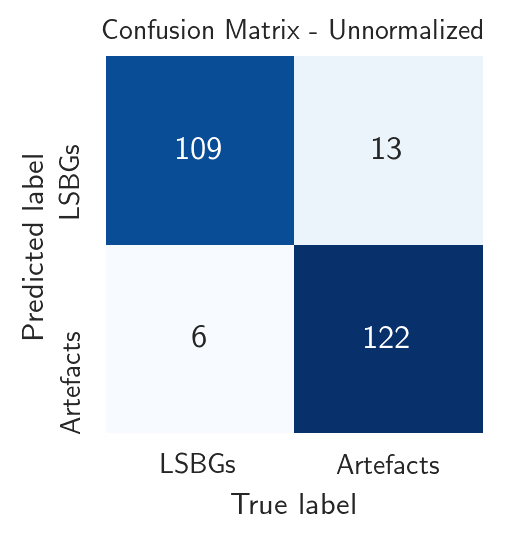

In [25]:
con_mat = confusion_matrix(y_test1, y_pred_1).T
plt.figure(figsize = (2.5,2.5))
plt.title('Confusion Matrix - Unnormalized',fontsize=10)
sns.heatmap(con_mat.T, square = True, annot=True, fmt='.0f', cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)

plt.xlabel('True label')
plt.ylabel('Predicted label')

plt.show()

Let's plot the missclassified ones. Those with true label = 'Artefacts', but classified as 'LSBGs', since we are interested in the purity of our final sample.

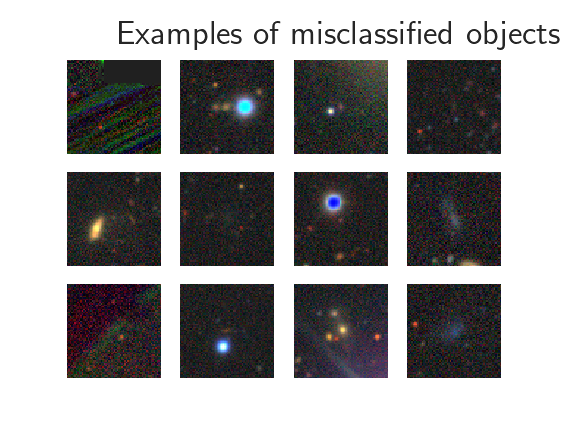

In [52]:
# Get those misclassified
X_test_misc = X_test1[(np.asarray(y_pred_1[:,0])==1)&(y_test1==0)]

# Plot them
nrows = 3
ncols = 4

plt.figure(figsize=(ncols*0.7, nrows*0.7))

for i in range(nrows*ncols):
    if (i==3):
        plt.title("Examples of misclassified objects")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(X_test_misc[i])
    plt.axis('off')
    
plt.axis('off')
plt.show()

We see that some of them are probably LSBGs or something very similar to LSBGs.

### Case II: Binary classification, LSBGs vs `Negative_sample_2` (Visually Rejected objects)

In [147]:
X_mat_ft2 = np.concatenate((LSBG_data,Neg_2_data)) # Features matrix
y_labels_ft2 = np.concatenate((np.ones(1000),np.zeros(1000))) # Labels 
# =====================================================================
# =====================================================================
# Now split in training, validation and test sets

# First in training and a set for validation and test - training set has 1500 instances 
X_tr2, X_valt2, y_tr2, y_valt2 = train_test_split(X_mat_ft2, y_labels_ft2, test_size=0.25, random_state=42)

# Now split in validation and test sets - 250 instances each
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_valt2, y_valt2, test_size=0.50, random_state=42)

In [148]:
# build the  original model
model2 = keras.models.Sequential()
model2.add(keras.layers.InputLayer((64,64,3)))
model2.add(keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model2.add(keras.layers.MaxPool2D())
model2.add(keras.layers.Dropout(rate=0.4))
model2.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model2.add(keras.layers.MaxPool2D())
model2.add(keras.layers.Dropout(rate=0.4))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(units=1024, activation='relu'))
model2.add(keras.layers.Dense(units=1, activation='sigmoid'))
model2.compile(optimizer=tf.train.AdadeltaOptimizer(0.1),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [149]:
model2.fit(x=X_tr2, y=y_tr2,
          epochs=20, batch_size=16,
          shuffle=True,
          validation_data=(X_val2,y_val2))

Train on 1500 samples, validate on 250 samples
Epoch 1/20
1500/1500 [==============================] - 74s 49ms/step - loss: 0.6744 - acc: 0.5673 - val_loss: 0.6639 - val_acc: 0.8480
Epoch 2/20
1500/1500 [==============================] - 18s 12ms/step - loss: 0.6198 - acc: 0.6813 - val_loss: 0.6125 - val_acc: 0.4960
Epoch 3/20
1500/1500 [==============================] - 16s 11ms/step - loss: 0.5421 - acc: 0.7553 - val_loss: 0.4966 - val_acc: 0.8840
Epoch 4/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.4593 - acc: 0.7980 - val_loss: 0.4471 - val_acc: 0.8200
Epoch 5/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.4146 - acc: 0.8253 - val_loss: 0.3713 - val_acc: 0.9000
Epoch 6/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3828 - acc: 0.8427 - val_loss: 0.3927 - val_acc: 0.8160
Epoch 7/20
1500/1500 [==============================] - 13s 9ms/step - loss: 0.3612 - acc: 0.8500 - val_loss: 0.3418 - val_acc: 0.8680
Epoch

Let's display the architecture of the convnet so far:

In [179]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 8192)              0         
__________

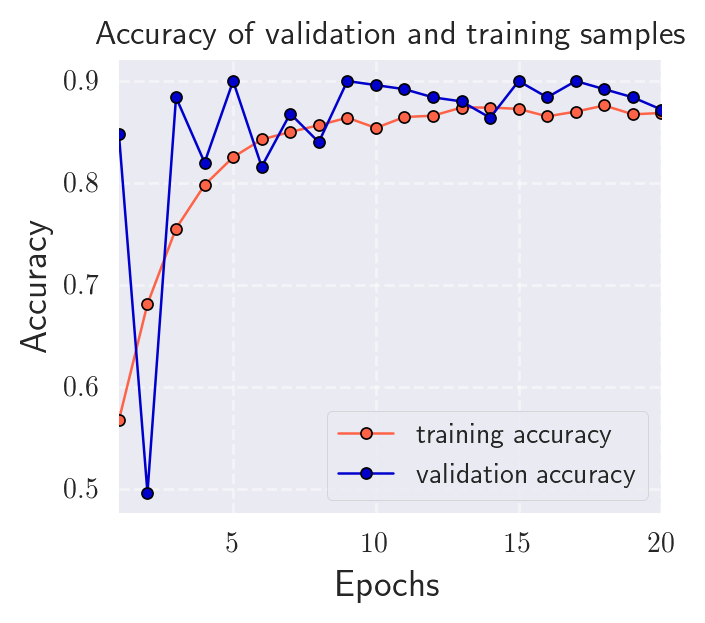

In [150]:
Epochs = np.arange(1,21,1)
history_dict = model2.history.history

train_acc = history_dict['acc']
val_acc = history_dict['val_acc']
train_err = 1.0 - np.asarray(train_acc)
val_err = 1.0 - np.asarray(val_acc)

plt.figure(figsize=(3.5, 3.0))

plt.plot(Epochs, train_acc, c = 'tomato', marker='o',
         markersize=4,linewidth=0.9,markeredgecolor='k',
         markeredgewidth=0.6,label='training accuracy')
plt.plot(Epochs, val_acc , c = 'mediumblue', marker='o',
         markersize=4,linewidth=0.9,markeredgecolor='k',
         markeredgewidth=0.6,label='validation accuracy')

plt.grid(ls='--',alpha=0.5)
plt.xlabel('Epochs', fontsize=13);plt.ylabel('Accuracy',fontsize=13)
plt.title('Accuracy of validation and training samples')
plt.xlim(1,20)

plt.legend(frameon=True, loc='lower right', fontsize=10)
plt.show()

In [151]:
# Now predict on the test set
y_pred_2 = model2.predict_classes(X_test2)
# Calculate the accuracy score of the model
acc_model2 = accuracy_score(y_test2, y_pred_2)
print(acc_model2)

0.868


We get an $86.8\%$ accuaracy on the test set. Let's check the confusion matrix.

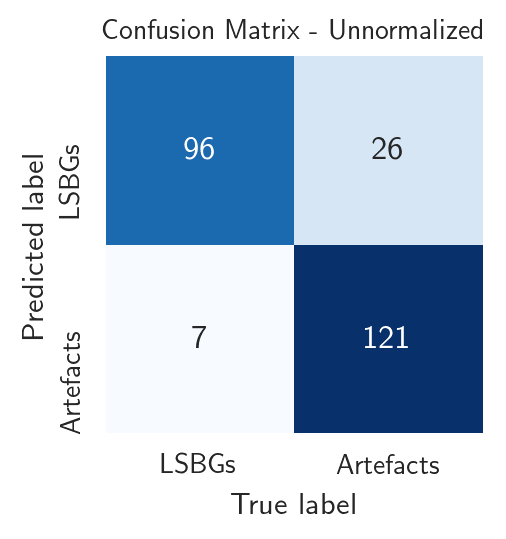

In [152]:
con_mat2 = confusion_matrix(y_test2, y_pred_2).T
plt.figure(figsize = (2.5,2.5))
plt.title('Confusion Matrix - Unnormalized',fontsize=10)
sns.heatmap(con_mat2.T, square = True, annot=True, fmt='.0f', cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)

plt.xlabel('True label')
plt.ylabel('Predicted label')

plt.show()

In practice we see that many artefacts were misclassified, actually something like $25\%$ of those classified as LSBGs are not. 

Let's plot the normalized confusion matrix:

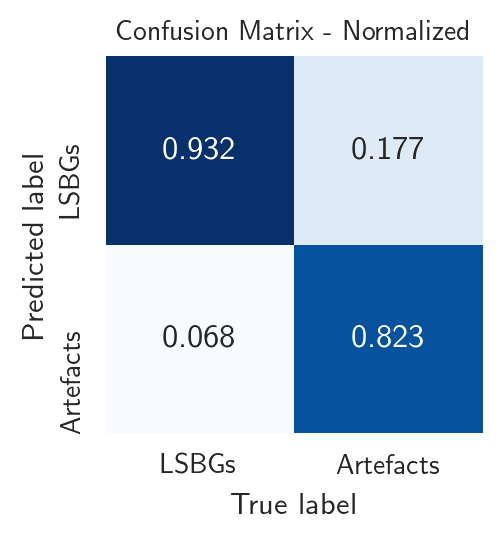

In [153]:
con_mat2 = confusion_matrix(y_test2, y_pred_2).T
con_mat2 = con_mat2.astype(float)
class_names = ['LSBGs', 'Artefacts']

norm_1 = np.sum(con_mat2[0,:])
norm_2 = np.sum(con_mat2[1,:])

con_mat2[0,:] = con_mat2[0,:]/np.float(norm_1)
con_mat2[1,:] = con_mat2[1,:]/np.float(norm_2)


plt.figure(figsize = (2.5,2.5))
plt.title('Confusion Matrix - Normalized',fontsize=10)
sns.heatmap(con_mat2.T, square = True, annot=True, fmt='.3f', cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)

plt.xlabel('True label')
plt.ylabel('Predicted label')

plt.show()

Finally let's plot some examples of misclassified artefacts.

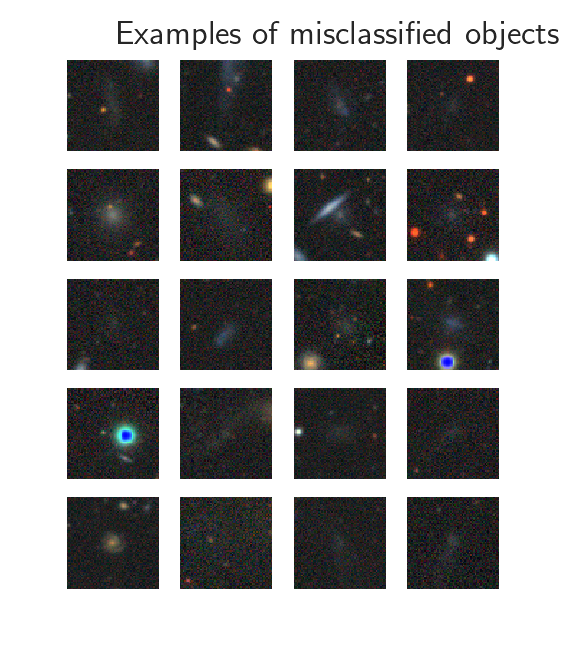

In [154]:
# Get those misclassified
X_test_misc = X_test2[(np.asarray(y_pred_2[:,0])==1)&(y_test2==0)]


# Plot them
nrows = 5
ncols = 4

plt.figure(figsize=(ncols*0.7, nrows*0.7))

for i in range(nrows*ncols):
    if (i==3):
        plt.title("Examples of misclassified objects")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(X_test_misc[i])
    plt.axis('off')
    
plt.axis('off')
plt.show()

These are really confusing objects, and maybe some of them are actually LSBGs! 
So, it is acceptable that the classifier was confused.

Let's also check the prediction of probabilities.

In [155]:
y_pred_proba = model2.predict_proba(X_test2)

y_pred_proba_pos = y_pred_proba[(y_test2==1)]
y_pred_proba_neg = y_pred_proba[(y_test2==0)]

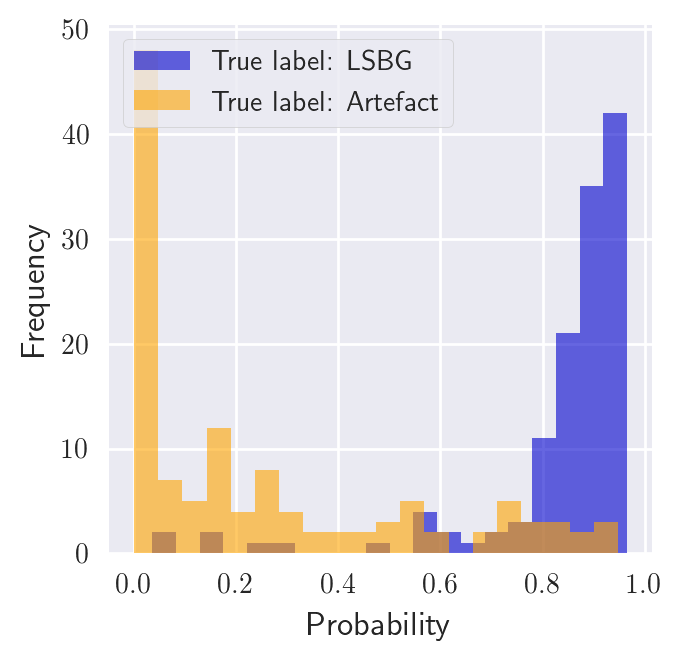

In [156]:
plt.figure(figsize=(3.5, 3.5))

plt.hist(y_pred_proba_pos, color='mediumblue', bins=20,alpha=0.6, label='True label: LSBG')
plt.hist(y_pred_proba_neg, color='orange',bins=20,alpha=0.6, label='True label: Artefact')

plt.xlabel('Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.legend(frameon=True, loc='upper left', fontsize=10)
plt.show()

### Case III: Multi-Class classfication

Now let's try to classify LSBGs vs `Negative_sample_1` vs `Negative_sample_2`

In [222]:
X_mat_tot = np.concatenate((LSBG_data,Neg_1_data,Neg_2_data)) # Features matrix
y_labels_tot = np.concatenate((np.full(1000,2),np.ones(1000),np.zeros(1000))) # Labels 

# ============================================================================
# ============================================================================
# Split into training, validation and test sets

# First in training and a set for validation and test - training set has 1500 instances 
X_tr_tot, X_valt_tot, y_tr_tot, y_valt_tot = train_test_split(X_mat_tot, y_labels_tot, test_size=0.25, random_state=42)

# Now split in validation and test sets - 250 instances each
X_val_tot, X_test_tot, y_val_tot, y_test_tot = train_test_split(X_valt_tot, y_valt_tot, test_size=0.50, random_state=42)

Now, encode to categorical

In [223]:
y_tr_tot_cat = tf.keras.utils.to_categorical(y_tr_tot)
y_val_tot_cat = tf.keras.utils.to_categorical(y_val_tot)
y_test_tot_cat = tf.keras.utils.to_categorical(y_test_tot)

In [224]:
# build the   model
model_tot = keras.models.Sequential()
model_tot.add(keras.layers.InputLayer((64,64,3)))
model_tot.add(keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model_tot.add(keras.layers.MaxPool2D())
model_tot.add(keras.layers.Dropout(rate=0.4))
model_tot.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model_tot.add(keras.layers.MaxPool2D())
model_tot.add(keras.layers.Dropout(rate=0.4))
model_tot.add(keras.layers.Flatten())
model_tot.add(keras.layers.Dense(units=1024, activation='relu'))
model_tot.add(keras.layers.Dense(units=3, activation='softmax'))
model_tot.compile(optimizer=tf.train.AdadeltaOptimizer(0.1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [225]:
model_tot.fit(x=X_tr_tot, y=y_tr_tot_cat,
          epochs=18, batch_size=16,
          shuffle=True,
          validation_data=(X_val_tot,y_val_tot_cat))

Train on 2250 samples, validate on 375 samples
Epoch 1/18
2250/2250 [==============================] - 81s 36ms/step - loss: 1.0290 - acc: 0.4587 - val_loss: 1.0039 - val_acc: 0.6213
Epoch 2/18
2250/2250 [==============================] - 19s 9ms/step - loss: 0.8653 - acc: 0.6253 - val_loss: 0.8834 - val_acc: 0.6480
Epoch 3/18
2250/2250 [==============================] - 20s 9ms/step - loss: 0.7617 - acc: 0.6658 - val_loss: 0.8101 - val_acc: 0.6773
Epoch 4/18
2250/2250 [==============================] - 25s 11ms/step - loss: 0.7239 - acc: 0.6827 - val_loss: 0.8055 - val_acc: 0.6533
Epoch 5/18
2250/2250 [==============================] - 25s 11ms/step - loss: 0.6853 - acc: 0.6969 - val_loss: 0.7520 - val_acc: 0.6880
Epoch 6/18
2250/2250 [==============================] - 20s 9ms/step - loss: 0.6595 - acc: 0.7018 - val_loss: 0.7347 - val_acc: 0.6907
Epoch 7/18
2250/2250 [==============================] - 27s 12ms/step - loss: 0.6432 - acc: 0.7196 - val_loss: 0.7417 - val_acc: 0.6720
Epoc

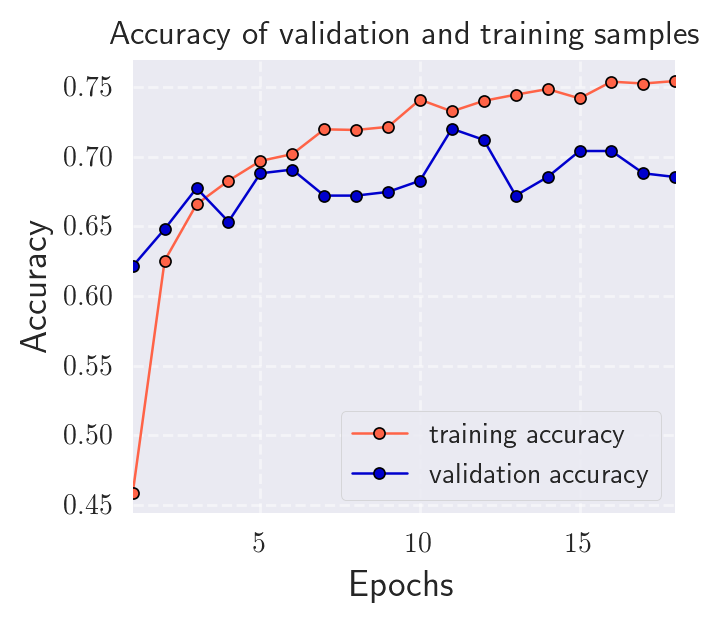

In [226]:
Epochs = np.arange(1,19,1)
history_dict = model_tot.history.history

train_acc = history_dict['acc']
val_acc = history_dict['val_acc']
train_err = 1.0 - np.asarray(train_acc)
val_err = 1.0 - np.asarray(val_acc)

plt.figure(figsize=(3.5, 3.0))

plt.plot(Epochs, train_acc, c = 'tomato', marker='o',
         markersize=4,linewidth=0.9,markeredgecolor='k',
         markeredgewidth=0.6,label='training accuracy')
plt.plot(Epochs, val_acc , c = 'mediumblue', marker='o',
         markersize=4,linewidth=0.9,markeredgecolor='k',
         markeredgewidth=0.6,label='validation accuracy')

plt.grid(ls='--',alpha=0.5)
plt.xlabel('Epochs', fontsize=13);plt.ylabel('Accuracy',fontsize=13)
plt.title('Accuracy of validation and training samples')
plt.xlim(1,18)

plt.legend(frameon=True, loc='lower right', fontsize=10)
plt.show()

In [227]:
# Now predict on the test set
y_pred_tot = model_tot.predict_classes(X_test_tot)
# Calculate the accuracy score of the model
acc_model_tot = accuracy_score(y_test_tot, y_pred_tot)
print(acc_model_tot)

0.7306666666666667


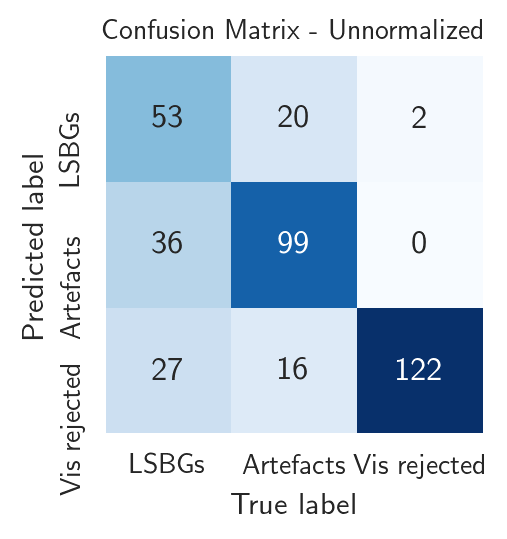

In [235]:
con_mat_tot = confusion_matrix(y_test_tot, y_pred_tot)
class_names = ['LSBGs', 'Artefacts', 'Vis rejected']
plt.figure(figsize = (2.5,2.5))
plt.title('Confusion Matrix - Unnormalized',fontsize=10)
sns.heatmap(con_mat_tot.T, square = True, annot=True, fmt='.0f', cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)

plt.xlabel('True label')
plt.ylabel('Predicted label')

plt.show()

In [237]:
print(len(y_test_tot[y_test_tot==2]))

124


## Part III: Use ResNet50

In this part I'll use the pre-defined Residual Neural Network ResNet50, as defined in the keras applications.

I will work only on a binary classification problem, with two classes: LSBGs and `Negative_sample_2` (the "difficult" problem).

In [129]:
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import *
model_res = Sequential()
model_res.add(ResNet50(include_top=False,weights=None,input_shape=(64,64,3),pooling=max))
model_res.add(Flatten())
model_res.add(Dense(units=1024, activation='relu'))
model_res.add(Dense(units=1, activation='sigmoid'))

//anaconda/envs/python2/lib/python2.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [131]:
model_res.compile(optimizer=tf.train.AdadeltaOptimizer(0.1),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_res.fit(x=X_tr2, y=y_tr2,
          epochs=10, batch_size=4*16,
          shuffle=True,
          validation_data=(X_val2,y_val2))

Train on 1500 samples, validate on 250 samples
Epoch 1/10
1500/1500 [==============================] - 248s 166ms/step - loss: 0.7321 - acc: 0.6480 - val_loss: 0.6948 - val_acc: 0.6760
Epoch 2/10
1500/1500 [==============================] - 202s 135ms/step - loss: 0.4783 - acc: 0.7693 - val_loss: 1.0141 - val_acc: 0.6280
Epoch 3/10
1500/1500 [==============================] - 203s 135ms/step - loss: 0.5168 - acc: 0.7413 - val_loss: 0.8893 - val_acc: 0.5800
Epoch 4/10
1500/1500 [==============================] - 215s 144ms/step - loss: 0.3856 - acc: 0.8173 - val_loss: 0.6221 - val_acc: 0.7440
Epoch 5/10
1500/1500 [==============================] - 239s 159ms/step - loss: 0.3070 - acc: 0.8693 - val_loss: 0.5913 - val_acc: 0.7280
Epoch 6/10
1500/1500 [==============================] - 245s 164ms/step - loss: 0.2200 - acc: 0.9193 - val_loss: 0.6027 - val_acc: 0.7320
Epoch 7/10
1500/1500 [==============================] - 216s 144ms/step - loss: 0.2059 - acc: 0.9140 - val_loss: 0.6285 - val

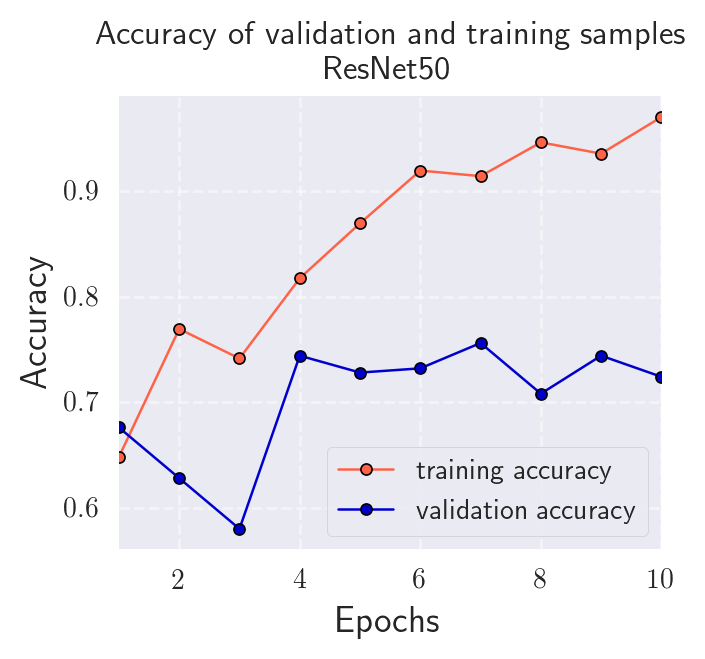

In [134]:
Epochs = np.arange(1,11,1)
history_dict = model_res.history.history

train_acc = history_dict['acc']
val_acc = history_dict['val_acc']
train_err = 1.0 - np.asarray(train_acc)
val_err = 1.0 - np.asarray(val_acc)

plt.figure(figsize=(3.5, 3.0))

plt.plot(Epochs, train_acc, c = 'tomato', marker='o',
         markersize=4,linewidth=0.9,markeredgecolor='k',
         markeredgewidth=0.6,label='training accuracy')
plt.plot(Epochs, val_acc , c = 'mediumblue', marker='o',
         markersize=4,linewidth=0.9,markeredgecolor='k',
         markeredgewidth=0.6,label='validation accuracy')

plt.grid(ls='--',alpha=0.5)
plt.xlabel('Epochs', fontsize=13);plt.ylabel('Accuracy',fontsize=13)
plt.title('Accuracy of validation and training samples\n ResNet50')
plt.xlim(1,10)

plt.legend(frameon=True, loc='lower right', fontsize=10)
plt.show()